In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(2)

Mounted at /content/drive


### Загружаем данные

In [2]:
with open('/content/drive/MyDrive/ml/nlp/full_description.txt') as f:
    full_description = eval(f.readlines()[0])

with open('/content/drive/MyDrive/ml/nlp/labels.txt') as f:
    labels = eval(f.readlines()[0])



### Подготовка данных к обучению

In [3]:
maxlen = 500  # Максимальная длинна
training_samples = int(len(labels)*0.80)  # 80% на обучение
validation_samples = len(labels) - training_samples  # 20% на тест
max_words = 10000  # Длина словаря

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(full_description)
sequences = tokenizer.texts_to_sequences(full_description)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Случайное перемешивание
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Формирование обучающей и валидационной частей выборки
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 184104 unique tokens.
Shape of data tensor: (14972, 500)
Shape of label tensor: (14972,)


In [ ]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
word_index

{'http': 1,
 'https': 2,
 's': 3,
 '’': 4,
 'news': 5,
 'video': 6,
 'show': 7,
 'new': 8,
 'us': 9,
 '2018': 10,
 'channel': 11,
 'music': 12,
 'videos': 13,
 'live': 14,
 'youtube': 15,
 'twitter': 16,
 'trump': 17,
 'nhttps': 18,
 'episode': 19,
 'tv': 20,
 'facebook': 21,
 'subscribe': 22,
 'get': 23,
 'full': 24,
 'n': 25,
 'instagram': 26,
 '”': 27,
 'best': 28,
 '»': 29,
 '“': 30,
 'watch': 31,
 'wwwyoutubecomwatch': 32,
 'official': 33,
 'food': 34,
 'first': 35,
 'funny': 36,
 'latest': 37,
 'world': 38,
 'like': 39,
 'game': 40,
 '►': 41,
 'time': 42,
 '2017': 43,
 'vs': 44,
 'season': 45,
 'comedy': 46,
 'one': 47,
 'life': 48,
 'nt': 49,
 'make': 50,
 'love': 51,
 'nba': 52,
 'use': 53,
 '2': 54,
 'late': 55,
 'nhttp': 56,
 'day': 57,
 'today': 58,
 'entertainment': 59,
 'top': 60,
 'makeup': 61,
 'family': 62,
 'jimmy': 63,
 'highlights': 64,
 '10': 65,
 'media': 66,
 'james': 67,
 'people': 68,
 '1': 69,
 'challenge': 70,
 'night': 71,
 'drama': 72,
 'sports': 73,
 'movie

### Загрузка 200-мерных эмбеддингов для 400 000 слов английского языка.

In [4]:
# Архив доступен на https://nlp.stanford.edu/projects/glove/

embeddings_index = {}

with open('/content/drive/MyDrive/ml/nlp/glove.6B.200d.txt') as fp:
    while True:
        try:
            line = fp.readline()
            if not line:
                break
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except (UnicodeDecodeError, ValueError, IndexError):
            continue

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Формирование весов слоя Embedding в виде матрицы размерности max_words х embedding_dim

In [5]:
embeddings_index['the']

array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
        3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
        1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
       -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
        4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
        7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
        1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
       -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
       -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
        6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
       -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
        8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
        1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
        1.4379e-01, -1.2325e-01, -5.8178e-02, -1.0290e-03, -8.21

In [6]:
embedding_dim = 200

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None and len(embedding_vector) == embedding_dim:
            embedding_matrix[i] = embedding_vector

In [7]:
embedding_matrix.shape

(10000, 200)

### Построение полносвязной НС со слоем Embedding

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 200)          2000000   
                                                                 
 flatten (Flatten)           (None, 100000)            0         
                                                                 
 dense (Dense)               (None, 1024)              102401024 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 105057409 (400.76 MB)
Trainable params: 10

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

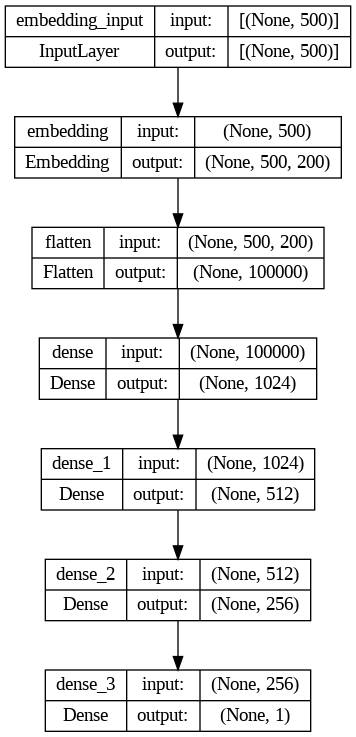

In [ ]:
tf.keras.utils.plot_model(model,show_shapes = True, show_layer_names = True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 3s 20ms/step - loss: 0.7712 - mae: 0.8357 - val_loss: 1.3770 - val_mae: 1.1520
Epoch 2/20
47/47 [==============================] - 1s 16ms/step - loss: 0.3251 - mae: 0.4123 - val_loss: 0.0648 - val_mae: 0.2306
Epoch 3/20
47/47 [==============================] - 1s 16ms/step - loss: 0.0490 - mae: 0.1682 - val_loss: 0.0447 - val_mae: 0.1288
Epoch 4/20
47/47 [==============================] - 1s 16ms/step - loss: 0.0458 - mae: 0.1604 - val_loss: 0.0503 - val_mae: 0.1967
Epoch 5/20
47/47 [==============================] - 1s 16ms/step - loss: 0.0453 - mae: 0.1596 - val_loss: 0.0523 - val_mae: 0.1412
Epoch 6/20
47/47 [==============================] - 1s 16ms/step - loss: 0.0439 - mae: 0.1572 - val_loss: 0.0535 - val_mae: 0.2059
Epoch 7/20
47/47 [==============================] - 1s 16ms/step - loss: 0.0426 - mae: 0.1553 - val_loss: 0.0551 - val_mae: 0.2097
Epoch 8/20
47/47 [==============================] - 1s 16ms/step - loss: 0.0427 - m

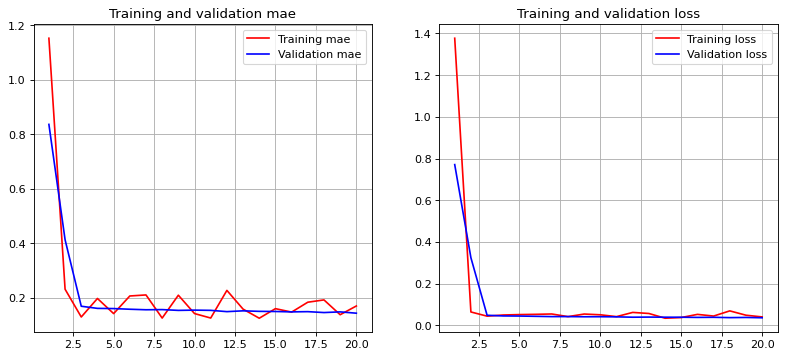

In [ ]:
val_mae = history.history['mae']
mae = history.history['val_mae']
val_loss = history.history['loss']
loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [ ]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.034821540117263794
min val loss = 0.0369764007627964
min train mae = 0.12421707063913345
min val mae = 0.14268594980239868


#### LSTM с embedding

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional


model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(1024,dropout=0.5))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.summary()
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 200)          2000000   
                                                                 
 lstm (LSTM)                 (None, 1024)              5017600   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 8723585 (33.28 MB)
Trainable params: 872

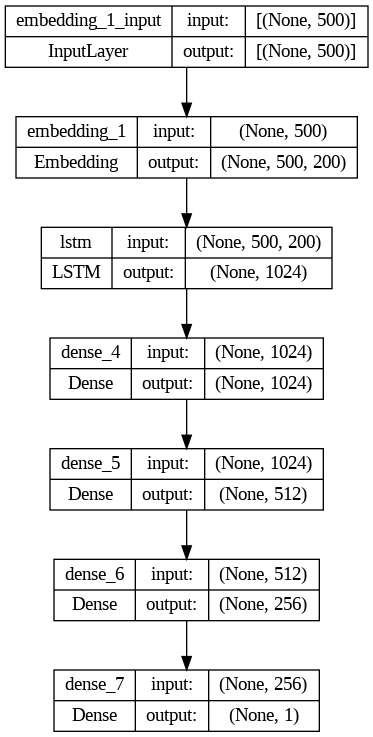

In [ ]:
tf.keras.utils.plot_model(model,show_shapes = True, show_layer_names = True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 22s 404ms/step - loss: 0.0598 - mae: 0.1744 - val_loss: 0.0480 - val_mae: 0.1839
Epoch 2/20
47/47 [==============================] - 19s 395ms/step - loss: 0.0349 - mae: 0.1339 - val_loss: 0.0357 - val_mae: 0.1320
Epoch 3/20
47/47 [==============================] - 19s 396ms/step - loss: 0.0326 - mae: 0.1282 - val_loss: 0.0357 - val_mae: 0.1474
Epoch 4/20
47/47 [==============================] - 19s 397ms/step - loss: 0.0314 - mae: 0.1260 - val_loss: 0.0337 - val_mae: 0.1311
Epoch 5/20
47/47 [==============================] - 19s 397ms/step - loss: 0.0312 - mae: 0.1252 - val_loss: 0.0359 - val_mae: 0.1502
Epoch 6/20
47/47 [==============================] - 19s 397ms/step - loss: 0.0307 - mae: 0.1245 - val_loss: 0.0340 - val_mae: 0.1251
Epoch 7/20
47/47 [==============================] - 19s 396ms/step - loss: 0.0307 - mae: 0.1242 - val_loss: 0.0333 - val_mae: 0.1367
Epoch 8/20
47/47 [==============================] - 19s 397ms/step - 

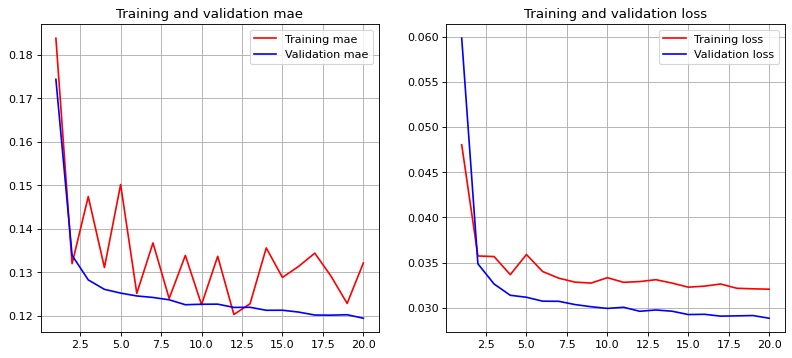

In [ ]:
val_mae = history.history['mae']
mae = history.history['val_mae']
val_loss = history.history['loss']
loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [ ]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.032053932547569275
min val loss = 0.028841907158493996
min train mae = 0.12026064842939377
min val mae = 0.11940041929483414


### Bi-LSTM с embedding

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(1024,dropout=0.5)))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


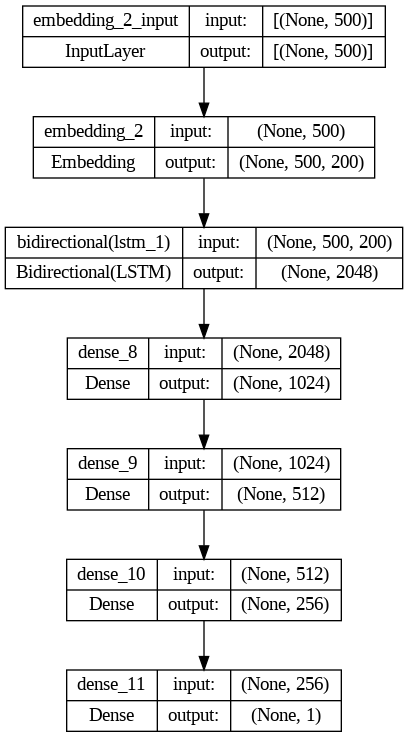

In [ ]:
tf.keras.utils.plot_model(model,show_shapes = True, show_layer_names = True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 42s 806ms/step - loss: 0.0520 - mae: 0.1621 - val_loss: 0.0361 - val_mae: 0.1471
Epoch 2/20
47/47 [==============================] - 37s 789ms/step - loss: 0.0340 - mae: 0.1310 - val_loss: 0.0407 - val_mae: 0.1594
Epoch 3/20
47/47 [==============================] - 37s 790ms/step - loss: 0.0323 - mae: 0.1278 - val_loss: 0.0336 - val_mae: 0.1334
Epoch 4/20
47/47 [==============================] - 37s 791ms/step - loss: 0.0310 - mae: 0.1250 - val_loss: 0.0350 - val_mae: 0.1211
Epoch 5/20
47/47 [==============================] - 37s 790ms/step - loss: 0.0312 - mae: 0.1255 - val_loss: 0.0330 - val_mae: 0.1263
Epoch 6/20
47/47 [==============================] - 37s 791ms/step - loss: 0.0305 - mae: 0.1237 - val_loss: 0.0354 - val_mae: 0.1197
Epoch 7/20
47/47 [==============================] - 37s 791ms/step - loss: 0.0303 - mae: 0.1231 - val_loss: 0.0329 - val_mae: 0.1330
Epoch 8/20
47/47 [==============================] - 37s 792ms/step - 

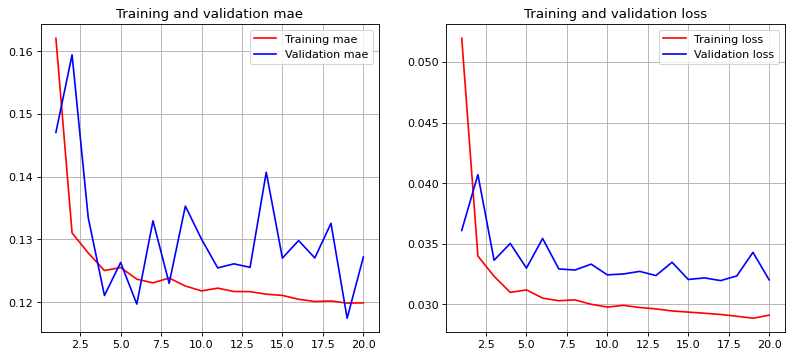

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [ ]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.028837900608778
min val loss = 0.03194452077150345
min train mae = 0.11984003335237503
min val mae = 0.11742625385522842


### Сверточная сеть


In [8]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Conv1D(64, 3, activation='tanh', input_shape=(None, embedding_dim)))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 5, activation='tanh'))
model.add(Flatten())
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))


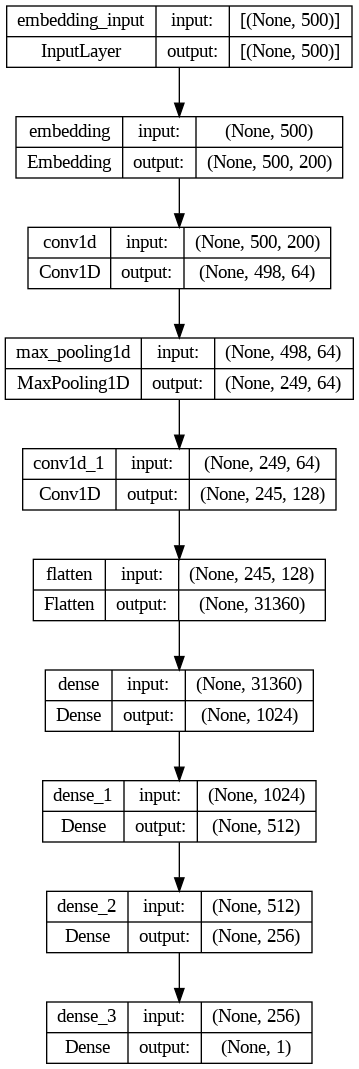

In [9]:
tf.keras.utils.plot_model(model,show_shapes = True, show_layer_names = True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 9s 123ms/step - loss: 0.2203 - mae: 0.3273 - val_loss: 0.0355 - val_mae: 0.1459
Epoch 2/20
47/47 [==============================] - 5s 102ms/step - loss: 0.0317 - mae: 0.1272 - val_loss: 0.0362 - val_mae: 0.1517
Epoch 3/20
47/47 [==============================] - 5s 96ms/step - loss: 0.0296 - mae: 0.1224 - val_loss: 0.0348 - val_mae: 0.1197
Epoch 4/20
47/47 [==============================] - 5s 98ms/step - loss: 0.0285 - mae: 0.1188 - val_loss: 0.0333 - val_mae: 0.1215
Epoch 5/20
47/47 [==============================] - 4s 87ms/step - loss: 0.0272 - mae: 0.1155 - val_loss: 0.0333 - val_mae: 0.1352
Epoch 6/20
47/47 [==============================] - 4s 78ms/step - loss: 0.0259 - mae: 0.1124 - val_loss: 0.0326 - val_mae: 0.1228
Epoch 7/20
47/47 [==============================] - 4s 84ms/step - loss: 0.0246 - mae: 0.1091 - val_loss: 0.0320 - val_mae: 0.1239
Epoch 8/20
47/47 [==============================] - 3s 72ms/step - loss: 0.0232 -

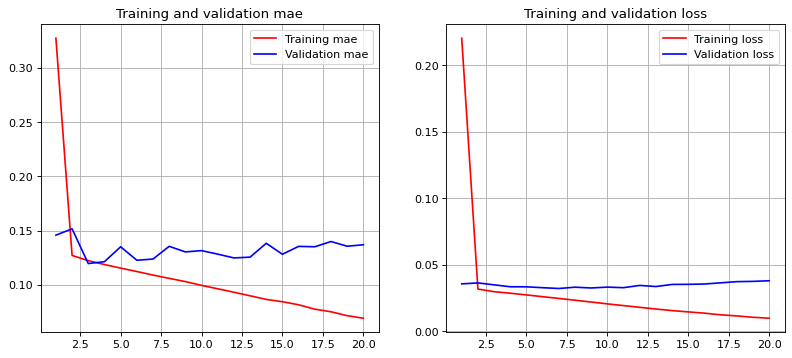

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [ ]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.009680674411356449
min val loss = 0.03203854337334633
min train mae = 0.06937198340892792
min val mae = 0.11972961574792862
